In [592]:
import numpy as np
import pandas as pd
import os,sys,inspect
import scipy.stats as stats
import scipy.optimize as opt
import scipy.integrate as integrate
from scipy.io import loadmat
import econtools 
import econtools.metrics as mt
import statsmodels.discrete.discrete_model as sm
import matplotlib.pyplot as plt
import itertools as it
import copy

# mine
# (1)
from demand_discrete_choice import initialize
from demand_discrete_choice import estimation 

# (2)
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir) 
import myfunctions as mf

import importlib
importlib.reload(initialize)
importlib.reload(estimation)
importlib.reload(mf)

<module 'myfunctions' from '/Users/jingyuanwang/GitHub/NU450_HW/myfunctions.py'>

In [593]:
#help(estimation)

In [594]:
# ------------------------------------------------------------------------
# NOTE
# ------------------------------------------------------------------------
# Purpose: HW2 Q2
# 
# test functions in the BLP_MPEC module
# ------------------------------------------------------------------------

# Initialize file path

In [595]:
rootpath = '/Users/jingyuanwang/Dropbox/Course/ECON/IO/NU450/NU450_HW/450-1-HW2'
datapath = rootpath + '/' + 'data'
resultpath = rootpath + '/' + 'results'

# Parameters
Everything should be input in the following cell. 
All other cells are just operation and calculation.

In [596]:
# model parameters (true value)
true_parameters = {'beta': np.array([5,1,1]),
                   'alpha_0': 1,
                   'alpha_sigma':1,
                   'gamma': np.array([2,1,1])}

# import file names
matfiles = ['10markets3products', '100markets3products','100markets5products']
names = ['m10_prod3', 'm100_prod3', 'm100_prod5']

# Import Data

In [597]:
# 1 import
inputfiles = dict(zip(names, matfiles))
data = {}
for name, filename in inputfiles.items():
    file = datapath + '/Simulation Data/'+ filename
    data[name] = loadmat(file)

In [598]:
# 2. clean and save to a class
def save_input_to_DiscreteChoiceClass(num_of_market, num_of_prod, include_outside_option, true_parameters):
    
    sample = 'm{}_prod{}'.format(num_of_market,num_of_prod)
    df_product = (pd.DataFrame(np.concatenate( 
                              (data[sample]['x1'],
                               data[sample]['xi_all'],
                               data[sample]['w'], 
                               data[sample]['Z'],
                               data[sample]['eta']), axis = 1 ))
                  .rename(columns = {0:'x1',1:'x2',2:'x3',3:'xi', 4:'w', 5:'z',6:'eta'}) )
    df_product['price'] = np.reshape(data[sample]['P_opt'].T, (num_of_market*num_of_prod,1))
    df_product['shares'] = np.reshape(data[sample]['shares'].T, (num_of_market*num_of_prod,1))

    df_product['product_id'] = (np.repeat(np.arange(num_of_prod)[:,np.newaxis],num_of_market, axis = 1)
                                .reshape((num_of_prod*num_of_market,1), order = 'F') )

    df_product['market_id'] = np.repeat(np.arange(num_of_market)[:, np.newaxis], num_of_prod, axis=0)
    product_ids = {'market_id':'market_id',
                   'product_id':'product_id'}

    # consumer
    df_consumer = pd.DataFrame(data[sample]['alphas'].T, columns=[idx for idx in range(num_of_market) ])
    df_consumer = df_consumer.stack().reset_index().rename(columns = {'level_0':'consumer_id', 
                                                                      'level_1':'market_id',
                                                                      0:'alpha'})


    consumer_ids = {'market_id':'market_id',
                   'consumer_id':'consumer_id'}
    
    output = initialize.DiscreteChoice(df_consumer, consumer_ids, 
                                     df_product, product_ids, include_outside_option = include_outside_option,
                                     true_parameters=true_parameters)
    return output

In [599]:
demand_m10_prod3 = save_input_to_DiscreteChoiceClass(num_of_market=10, 
                                                     num_of_prod=3, 
                                                     include_outside_option = False,
                                                     true_parameters = true_parameters)

In [600]:
demand_m100_prod3 = save_input_to_DiscreteChoiceClass(num_of_market=100, 
                                                     num_of_prod=3, 
                                                     include_outside_option = False,
                                                     true_parameters = true_parameters)

In [601]:
demand_m100_prod5 = save_input_to_DiscreteChoiceClass(num_of_market=100, 
                                                     num_of_prod=5, 
                                                     include_outside_option = False,
                                                     true_parameters = true_parameters)

# Q2. Estimation: Demand side instrument

## 1. get sample data

In [602]:
true_parameters = {'beta': np.array([5,1,1]),
                   'alpha_0': 1,
                   'alpha_sigma':1,
                   'gamma': np.array([2,1,1])}

In [603]:
sample = estimation.BLP_MPEC(demand_m100_prod3, true_parameters, update=True)
sample.construct_exogenous_var()

## 2. import knitro output

In [604]:
# load config
def import_knitro_output(specification):
    # read configs that defines the subsample

    results = pd.read_csv('knitro_output/result_from_knitro_opt_{}.csv'.format(specification), header=0,index_col = 0)
    delta_hat = results['delta_sigma_eta'].values[:300]
    sigma_hat = results['delta_sigma_eta'].values[300]
    eta_hat = results['delta_sigma_eta'].values[301:]
    
    beta_hat = results['betas'].values[:3]
    alpha_hat = results['betas'].values[3]
    
    specification = results['specification'].iloc[0]
    IV_varnames = results['IV_varnames'].dropna().tolist()
    
    np.set_printoptions(precision=3, suppress = True)
    print('--parameters: betas, alpha, sigma')
    print(beta_hat)
    print('{0:.3f}'.format(alpha_hat))
    print('{0:.3f}'.format(sigma_hat))
    
    return (delta_hat, sigma_hat, eta_hat, beta_hat, alpha_hat, specification, IV_varnames, results)

In [605]:
specification = 'iv_BLP_hausman_w'
#specification = 'iv_hausman'

(delta_hat, sigma_hat, eta_hat, 
 beta_hat, alpha_hat, specification, IV_varnames, results) = import_knitro_output(specification)

--parameters: betas, alpha, sigma
[5.038 0.976 1.041]
-0.976
1.016


In [606]:
IV_varnames

['x2_other1', 'x2_other2', 'x3_other1', 'x3_other2', 'price_others', 'w']

## 3. get elasticity

In [607]:
# get sample
independent_var = ['x1', 'x2', 'x3', 'price']
exogenous_var = ['x1', 'x2', 'x3'] + IV_varnames

sample.MPEC_claim_var(independent_var,exogenous_var, supply_side = True)

In [608]:
derivative = sample.derivative_demand_to_price(delta_hat,sigma_hat,alpha_hat)

In [609]:
# elasticity
df = sample.products
df['elas_p'] = -(df['shares'] / df['price'] )/ alpha_hat

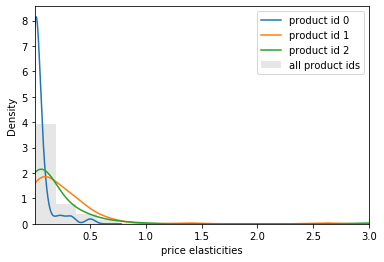

In [610]:
mf.hist_and_kdensity_bygroup(df, 'elas_p', 'price elasticities', 'product_id', 'product id',
                            save = True, figpath= resultpath + '/Q3' , 
                             figname = 'dist_elas_p_DemandSideEst_w_m{}_prod{}'.format(100,3))

## 4. Back out marginal cost and supply side parameter estimation

In [611]:
#delta_true = sample.MPEC_par_true_delta
#could check delta_true
mc = sample.get_marginal_cost(delta_hat,sigma_hat,alpha_hat)
mc_comp = sample.get_marginal_cost(delta_hat,sigma_hat,alpha_hat,market_structure='competition')
mc_coll = sample.get_marginal_cost(delta_hat,sigma_hat,alpha_hat,market_structure='collusion')

In [613]:
# compare with true mc
df = sample.products.copy()
df['mc_hat'] = mc
df['mc_hat_comp'] = mc_comp
df['mc_hat_coll'] = mc_coll
df['mc_true'] = 2 + df['w'] + df['z'] + df['eta']
mc_true = df['mc_true'].values[:, np.newaxis]

In [614]:
sample.get_alpha_beta(delta_hat[:,np.newaxis])

array([[ 5.038],
       [ 0.976],
       [ 1.041],
       [-0.976]])

In [625]:
# Get Gammas using a separated estimation
sample.get_gamma(mc_comp, worried_about_endogeneity=False)

array([[2.921],
       [0.749]])

In [616]:
# The first stage of instrumenting Z using X
sample.first_stage(exogenous_varname = ['w'], 
                     endogenous_varname = ['z'], 
                     IV_varname =  ['x1', 'x2', 'x3'] )

#=======================================================
Endogenous var: z 
            IV: ['x1', 'x2', 'x3'] 
 
Ftest = (1.0457474586198903, 0.3726045228914381)
 
regression:
Dependent variable:	z
N:			300
R-squared:		0.0099
Estimation method:	OLS
VCE method:		Standard (Homosk.)
    coeff    se      t   p>t CI_low CI_high
w  -0.025 0.071 -0.354 0.723 -0.165   0.115
x1 -0.054 0.120 -0.452 0.651 -0.290   0.182
x2  0.040 0.203  0.195 0.846 -0.360   0.439
x3 -0.098 0.060 -1.630 0.104 -0.217   0.020

 


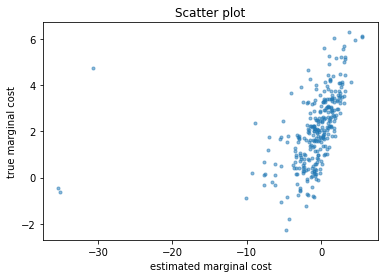

In [620]:
plot_fit(df['mc_true'], df['mc_hat_coll'], ylabel = 'true marginal cost', xlabel = 'estimated marginal cost')

# Draft & Appendix

In [369]:
def plot_fit(yvar, xvar, ylabel = None, xlabel = None):

        # Figure parameters
        area = np.pi*3
        # Plot
        plt.figure()
        plt.scatter(xvar, yvar, s=area, alpha=0.5)
        plt.title('Scatter plot')
        if xlabel != None:
            plt.xlabel(xlabel)
        if ylabel != None:
            plt.ylabel(ylabel)
        plt.show()